# WHO: Life Expectancy Dataset
**Project Goals**:
 - Wrangle WHO dataset by acquiring and cleaning the data to increase usability for project.
 - Utilize wrangled dataframe to explore correlating features to life expectancy via visualizations, statistical testing and possible clustering methods.
 - Create machine learning models to predict life expectancy and compare end result to baseline model.

**Findings:**
 - Through visual exploration and statistical testing, I was able to confirm my suspicion of top features for my model.
 - Using the recursive feature method, I confirmed which features would make it into my final model.
 - I first created a baseline model using the mean average of life expectancy and initially obtained an RMSE score of 9.2. This score was pretty high considering life expecting was off by an average of 8 years.
 - I then created four competitive models using multiple different algorithms.
 - Three models using LinearRegression and PolynomialRegression outperformed my baseline by over 50%
 - In the end I moved forward with Model 5 (PolynomialRegression with a degree of 3) to test on the unseen test data set. The results were as follows:
    - train dataset: RMSE = 2.72
    - validate (unseen) dataset: RMSE = 3.27
    - test (unseen) dataset: RMSE = 3.43
- Though there is a small chance of overfitting, Model 5 performed well all around on unseen data. 

In [1]:
import pandas as pd
import numpy as np
import wrangle
import explore

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.cluster import KMeans

## Acquire Data

In [2]:
df = wrangle.acquire_who_data()

In [3]:
df.sample(5).T

,2635,1258,160,2235,2486
Country,Tonga,Ireland,Bahamas,Saudi Arabia,Suriname
Year,2013,2007,2015,2013,2002
Status,Developing,Developed,Developing,Developing,Developing
Life expectancy,73.2,79.5,76.1,74.3,67.9
Adult Mortality,137,75,147,89,221
infant deaths,0,0,0,8,0
Alcohol,0.01,13.59,NaN,0.09,4.41
percentage expenditure,584.945,9797.55,0,2047.11,250.711
Hepatitis B,82,NaN,95,98,NaN
Measles,0,64,0,1164,0


In [4]:
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2336,Slovakia,2008,Developed,74.7,136.0,0,11.37,0.000000,99.0,0,...,99.0,8.20,99.0,0.1,NaN,NaN,1.3,1.4,0.813,14.8
2729,Uganda,2000,Developing,46.6,554.0,116,10.47,22.594475,NaN,42554,...,55.0,6.77,52.0,11.6,257.63369,2439274.0,7.0,7.0,0.382,9.8
1202,Indonesia,2015,Developing,69.1,176.0,114,NaN,0.000000,78.0,15099,...,8.0,NaN,78.0,0.3,3336.16686,258162113.0,1.4,1.2,0.686,12.9


### Acquire Takeaways:
 - I brought in my data using my acquire function
 - My info function gives me insight into the data types and null counts in my df
 - I will need to strip whitespaces from column names, lowercase and rename as well.
 - I will definitely need to impute some nulls because dropping would be too much
 - A distplot will give me a good idea of how to impute our nulls

## Prepare Data

In [5]:
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [6]:
df = wrangle.prep_who(df)

In [7]:
df.head()

,country,year,developed_country,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hep_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19yrs,thinness_5-9yrs,income_comp_resources,yrs_education
0,Afghanistan,2015,0,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,0,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


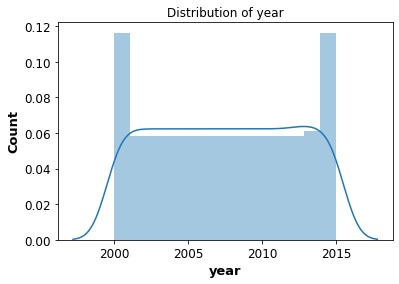

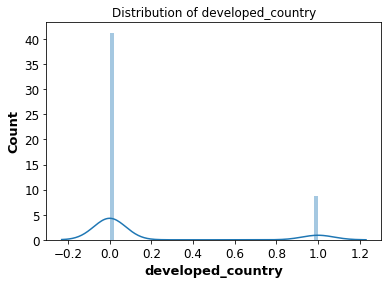

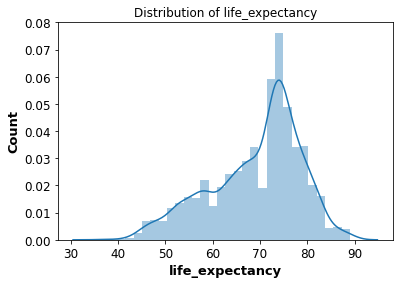

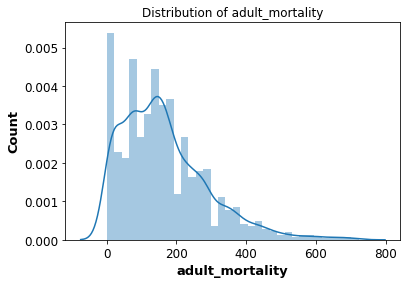

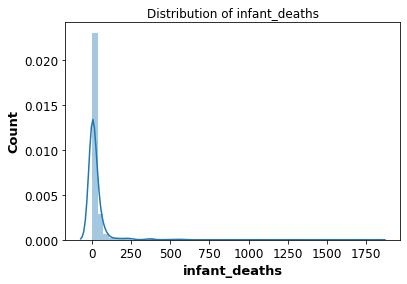

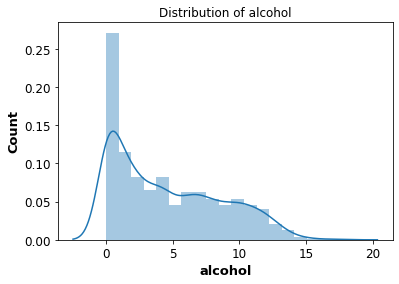

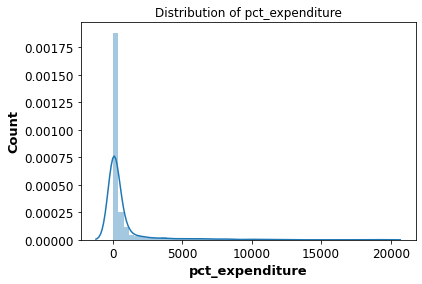

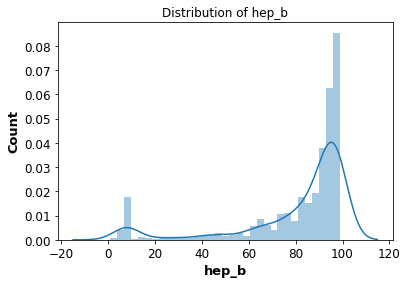

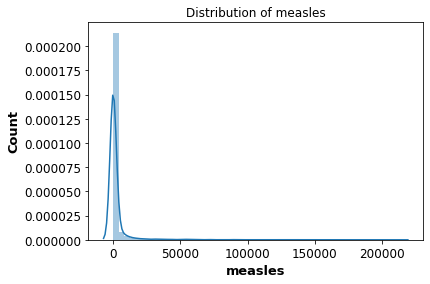

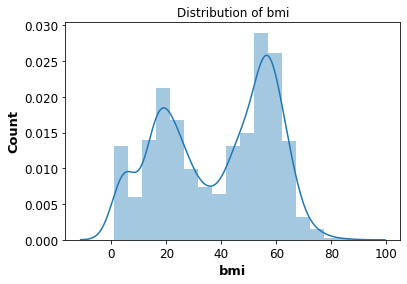

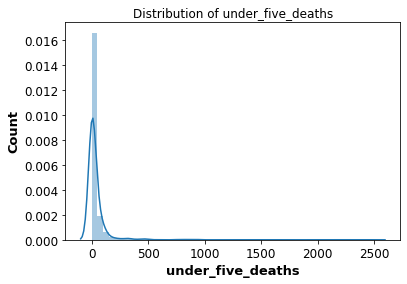

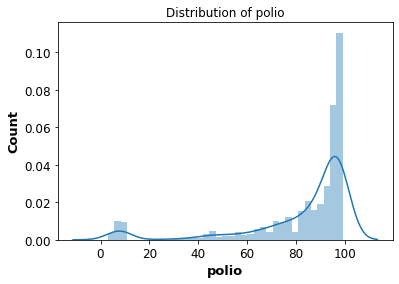

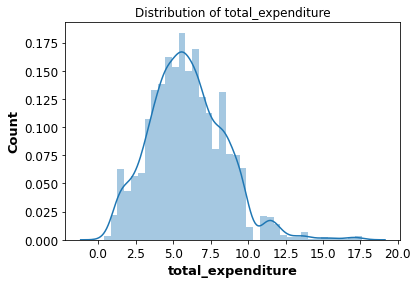

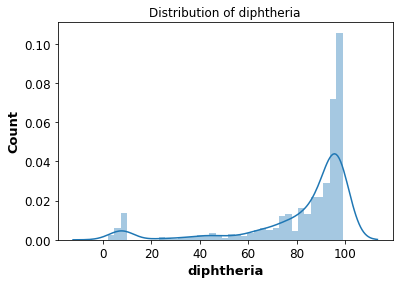

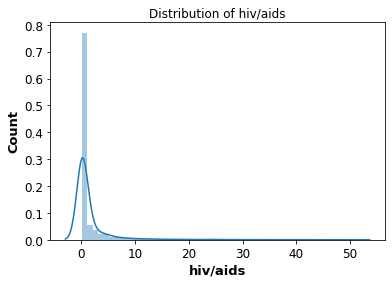

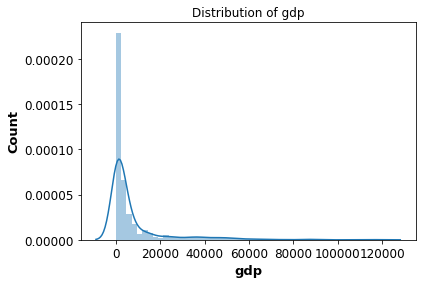

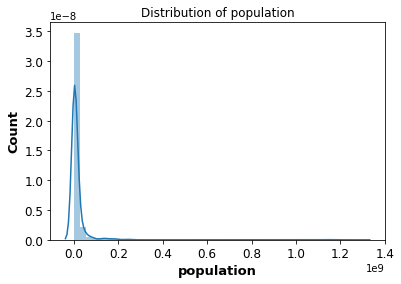

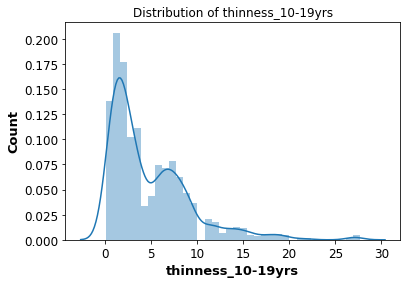

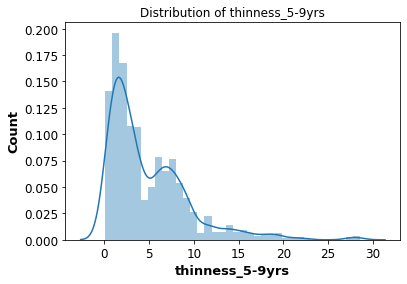

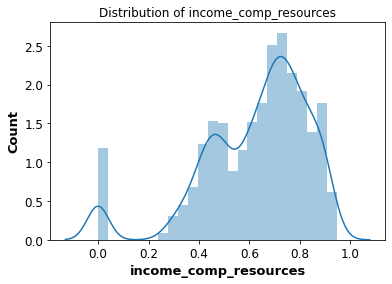

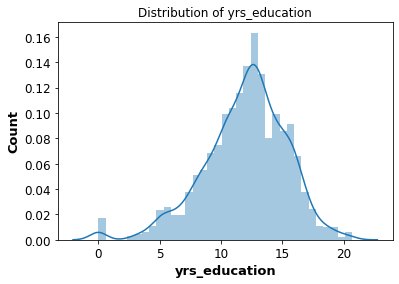

In [8]:
# take a look at distributions of numerical columns using my distplot function 
# get a better handle on the distribution to impute null entries
explore.distplot(df, df.columns)

In [9]:
df.sample(10).T

,1327,1098,1083,1133,2538,252,888,2863,2456,942
country,Japan,Guinea-Bissau,Guinea,Haiti,Syrian Arab Republic,Belgium,Ethiopia,Venezuela (Bolivarian Republic of),Sri Lanka,France
year,2002,2007,2006,2004,2014,2003,2009,2010,2000,2003
developed_country,1,0,0,0,0,1,0,0,0,0
life_expectancy,81.8,55,55.6,58.7,64.4,78.3,68,73.7,71.5,79.3
adult_mortality,7,32,317,32,294,95,274,158,175,99
infant_deaths,3,5,31,18,7,0,169,9,5,3
alcohol,7.87,2.98,0.16,6.1,0.01,11.28,1.17,7.22,1.45,13.49
pct_expenditure,5250.25,31.0693,10.3839,64.3985,0,507.306,53.7735,0,60.491,4572.44
hep_b,NaN,NaN,NaN,NaN,47,64,56,78,NaN,28
measles,33812,1,4,0,594,44,1176,0,16527,0


In [10]:
# investigate the nulls
df.isnull().sum()

country                    0
year                       0
developed_country          0
life_expectancy           10
adult_mortality           10
infant_deaths              0
alcohol                  194
pct_expenditure            0
hep_b                    553
measles                    0
bmi                       34
under_five_deaths          0
polio                     19
total_expenditure        226
diphtheria                19
hiv/aids                   0
gdp                      448
population               652
thinness_10-19yrs         34
thinness_5-9yrs           34
income_comp_resources    167
yrs_education            163
dtype: int64

In [11]:
# handle the nulls using the function I created for the dataframe
df = wrangle.handle_who_nulls(df)

In [12]:
# double check nulls are handled
df.isnull().sum()

country              0
year                 0
developed_country    0
life_expectancy      0
adult_mortality      0
infant_deaths        0
alcohol              0
pct_expenditure      0
hep_b                0
measles              0
bmi                  0
under_five_deaths    0
polio                0
total_expenditure    0
diphtheria           0
hiv/aids             0
thinness_10-19yrs    0
thinness_5-9yrs      0
yrs_education        0
dtype: int64

In [13]:
# check how much of the data we're left with
df.shape

(2709, 19)

In [14]:
# split data for exploration and scaling
train, validate, test = wrangle.split_data(df)

train---> (1516, 19)
validate---> (651, 19)
test---> (542, 19)


In [15]:
# use robust scaler on my dataframe, using robust because some of the data is skewed and 
# has some outliers that cannot be addressed

# assign the columns I want to scale
numeric_cols = ['year', 'adult_mortality', 'infant_deaths', 'pct_expenditure',
               'measles', 'under_five_deaths', 'yrs_education']

# use my robust scaler function to scaled my X dataframes
train_scaled, validate_scaled, test_scaled, scaler = wrangle.robust_scaler(train, validate, test, numeric_cols)

### Prepare Takeaways:
 - Used my prep function to rename columns and hot encode developed countries into discrete variable
 - Visualized distribution to assess how to fill my null values and which were necessary to drop
 - Created a handle nulls function to impute null values with mean average and backfill values grouped by country
 - Split my data for exploration and modeling
 - Used robust scaler to scale my numeric columns

## Explore

In [16]:
# visualize distribution of ytarget
train_scaled.sample(5).T

,979,2456,1546,954,1003
country,Georgia,Sri Lanka,Luxembourg,Gabon,Germany
year,0.875,-0.875,0,0,-0.125
developed_country,0,0,1,0,1
life_expectancy,74.5,71.5,79.7,61.6,79.6
adult_mortality,-0.146423,0.186356,-0.432612,0.958403,-0.419301
infant_deaths,-0.0869565,0.0869565,-0.130435,-0.0434783,0
alcohol,6.13,1.45,11.75,9.02,11.76
pct_expenditure,0.39798,-0.00849402,0.513031,1.21591,16.0166
hep_b,91,90.6154,87,75,87
measles,8.07129,42.0344,-0.0458307,-0.0458307,5.82813


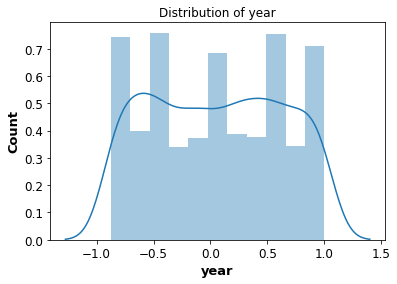

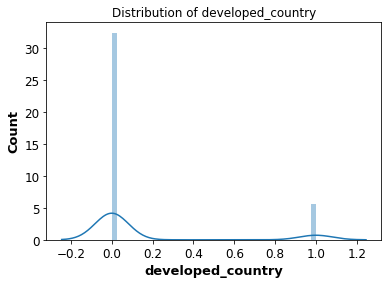

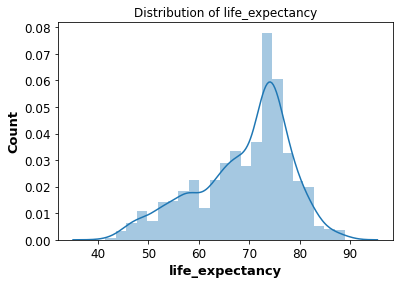

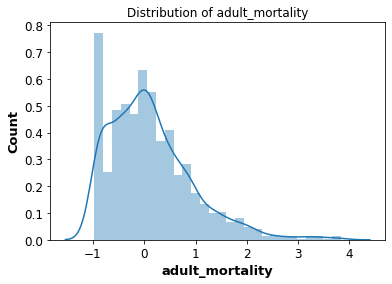

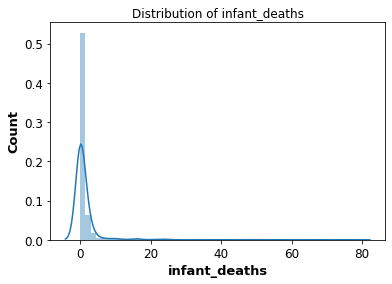

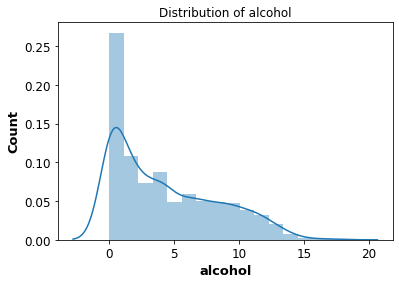

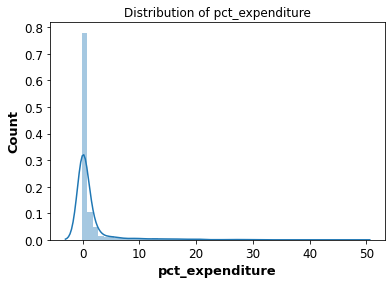

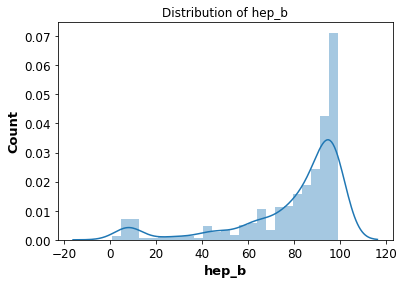

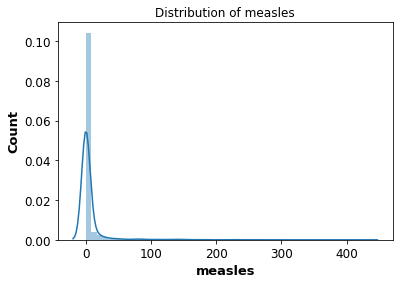

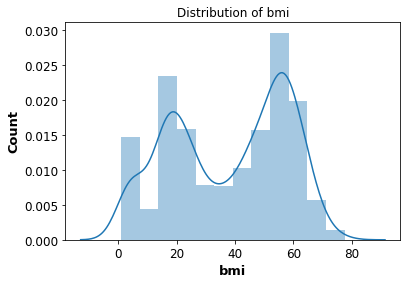

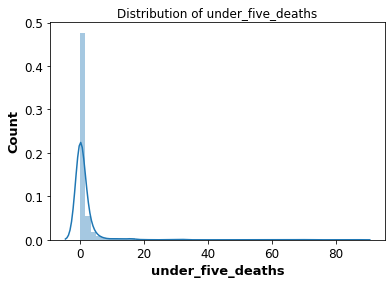

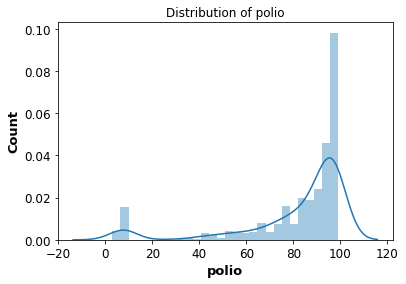

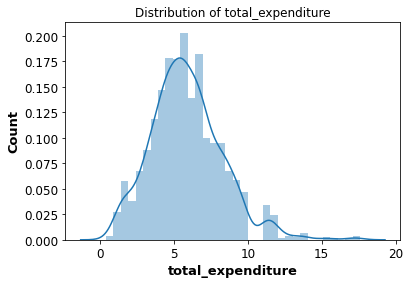

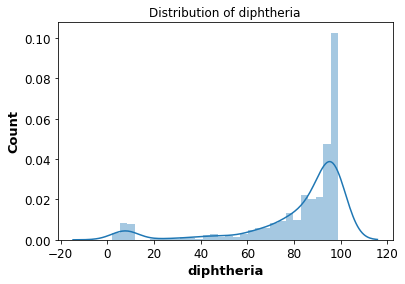

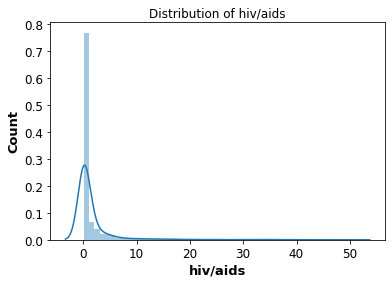

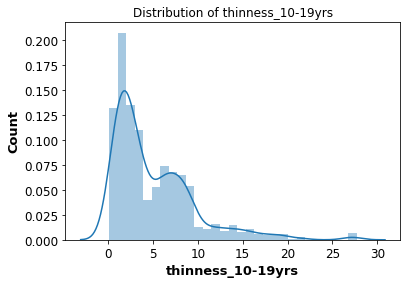

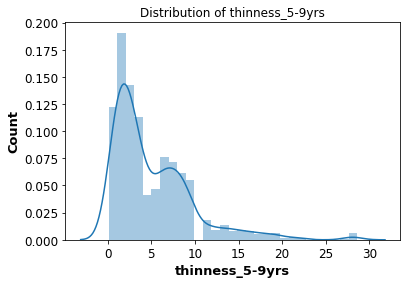

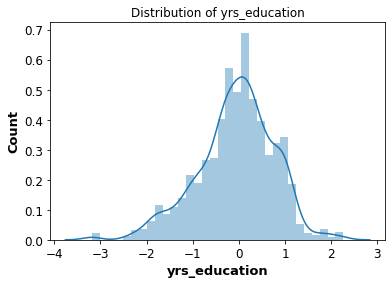

In [17]:
explore.distplot(train_scaled, train_scaled.columns)

In [18]:
train_scaled.dtypes

country               object
year                 float64
developed_country      int64
life_expectancy      float64
adult_mortality      float64
infant_deaths        float64
alcohol              float64
pct_expenditure      float64
hep_b                float64
measles              float64
bmi                  float64
under_five_deaths    float64
polio                float64
total_expenditure    float64
diphtheria           float64
hiv/aids             float64
thinness_10-19yrs    float64
thinness_5-9yrs      float64
yrs_education        float64
dtype: object

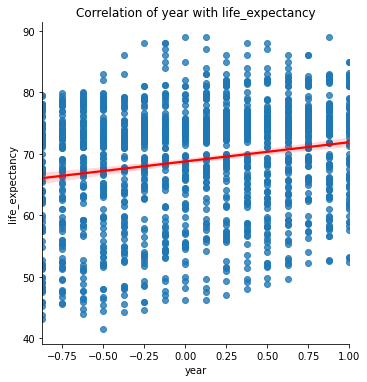

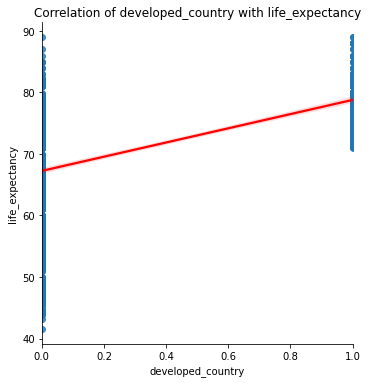

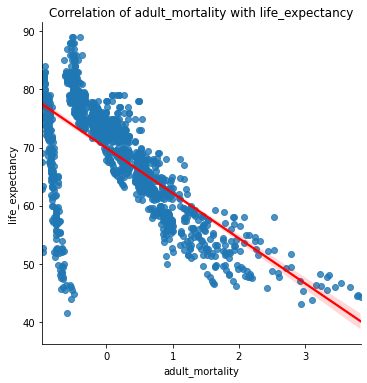

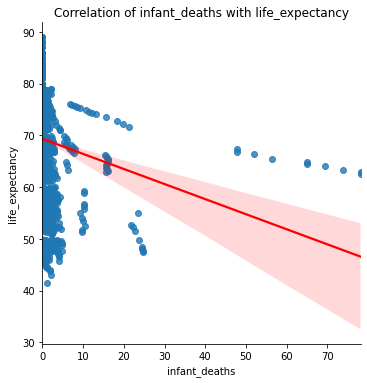

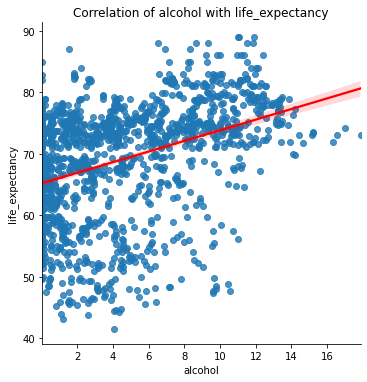

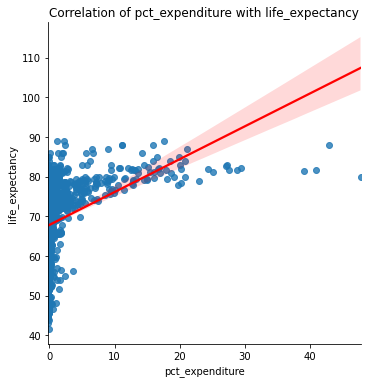

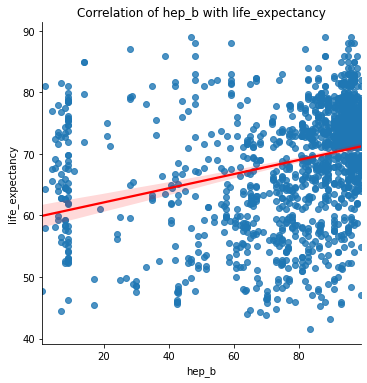

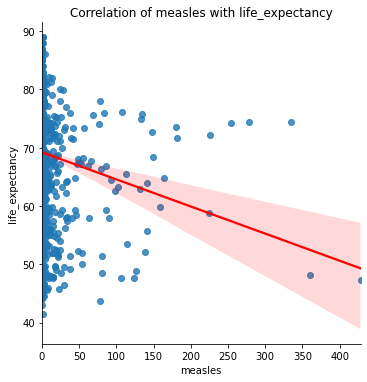

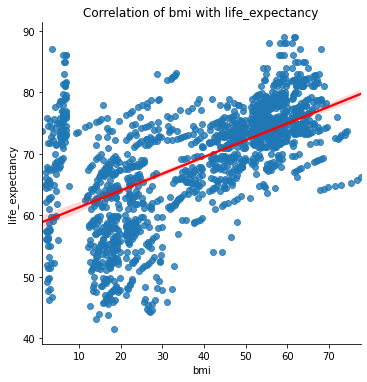

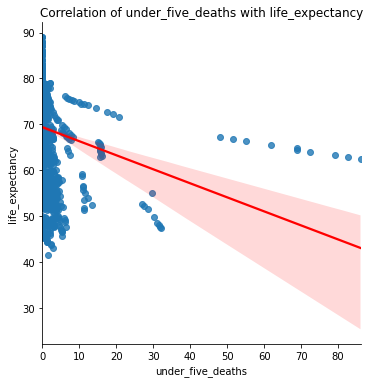

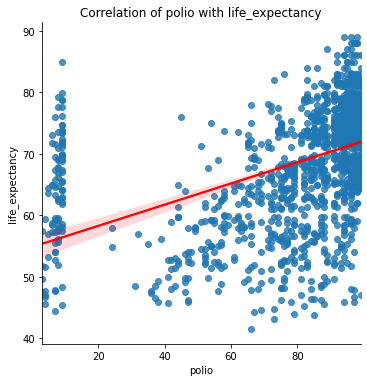

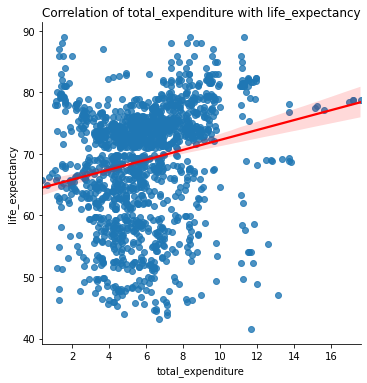

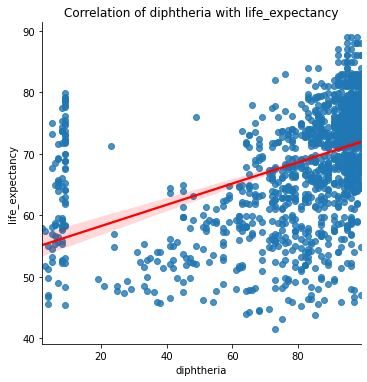

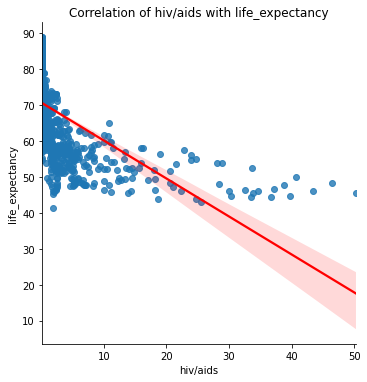

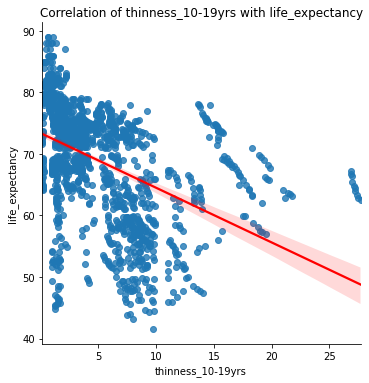

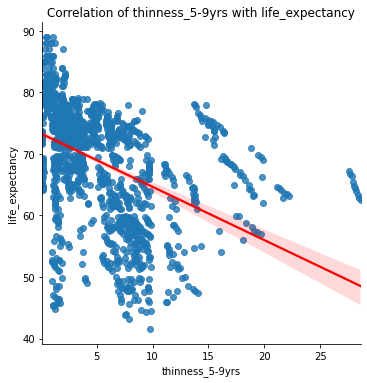

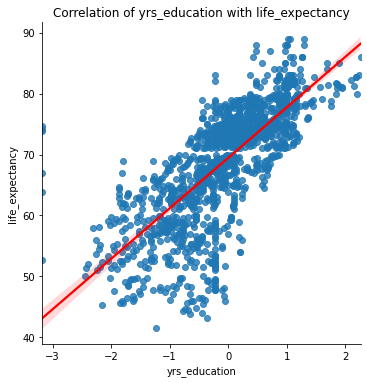

In [19]:
X = train_scaled.drop(columns=['life_expectancy', 'country'])
y = 'life_expectancy'
explore.lmplot(X, y, train_scaled)

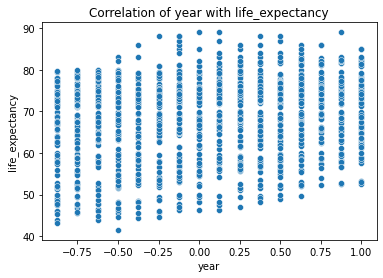

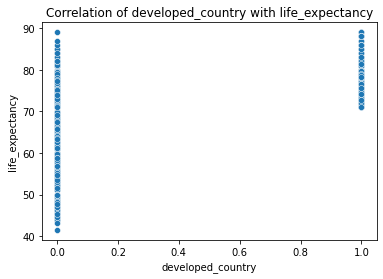

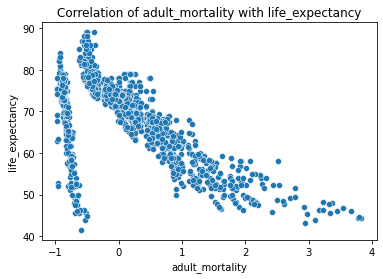

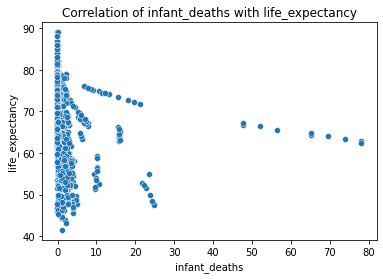

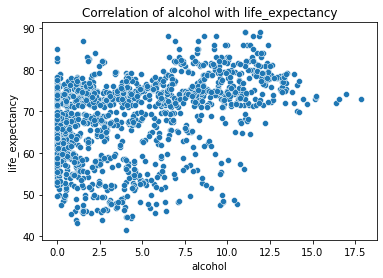

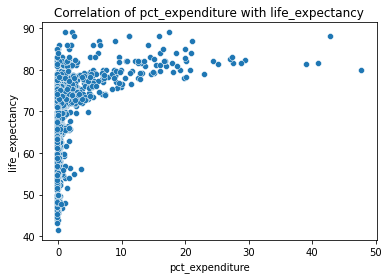

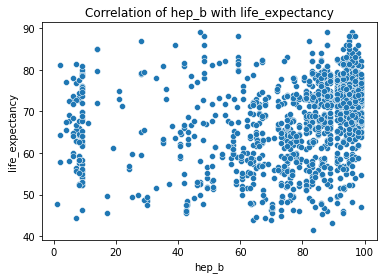

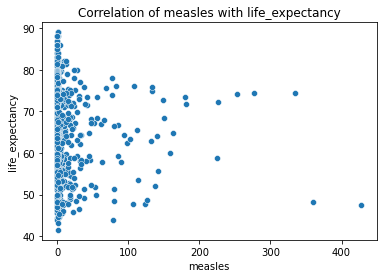

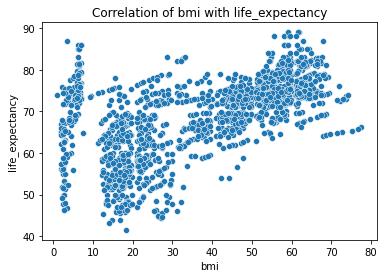

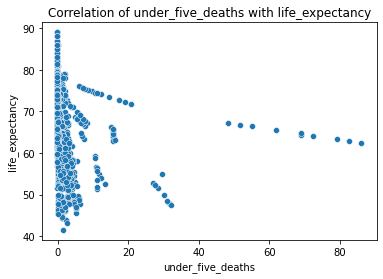

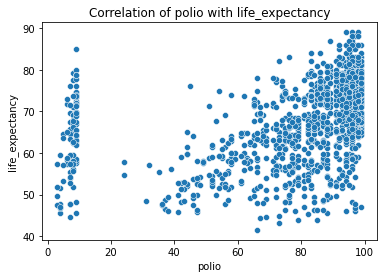

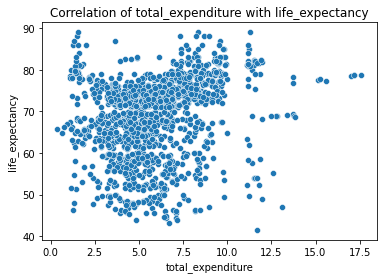

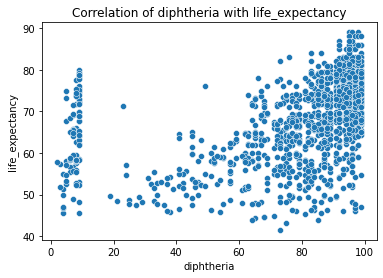

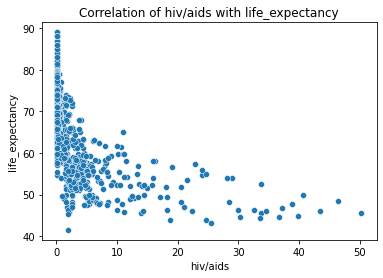

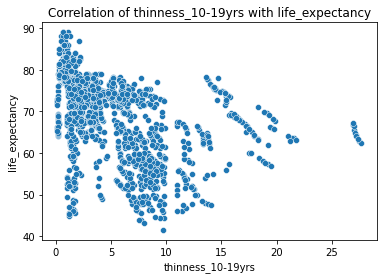

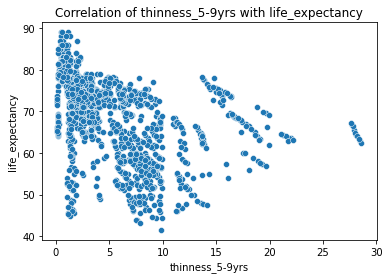

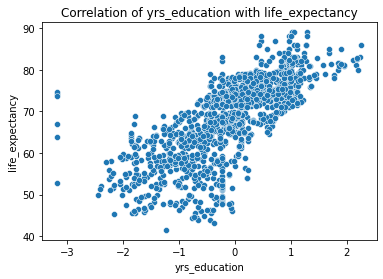

In [50]:
# take a look at correlation
X = train_scaled.drop(columns=['life_expectancy', 'country'])
y= 'life_expectancy'

explore.scatterplot(X, y, train_scaled)

**Takeaway**
\
There is really good potential for some clusters here. There aren't any major correlations save for a few features. Clustering would help a lot here. Hopefully there is more time after initial completion to create some clusters.

**Clustering?**

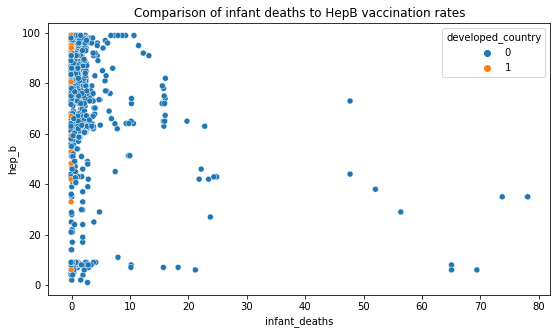

In [21]:
# take a look at cluster possibilities
plt.figure(figsize=(9,5))
sns.scatterplot(x='infant_deaths', y='hep_b', data=train_scaled, hue='developed_country')
plt.title('Comparison of infant deaths to HepB vaccination rates');

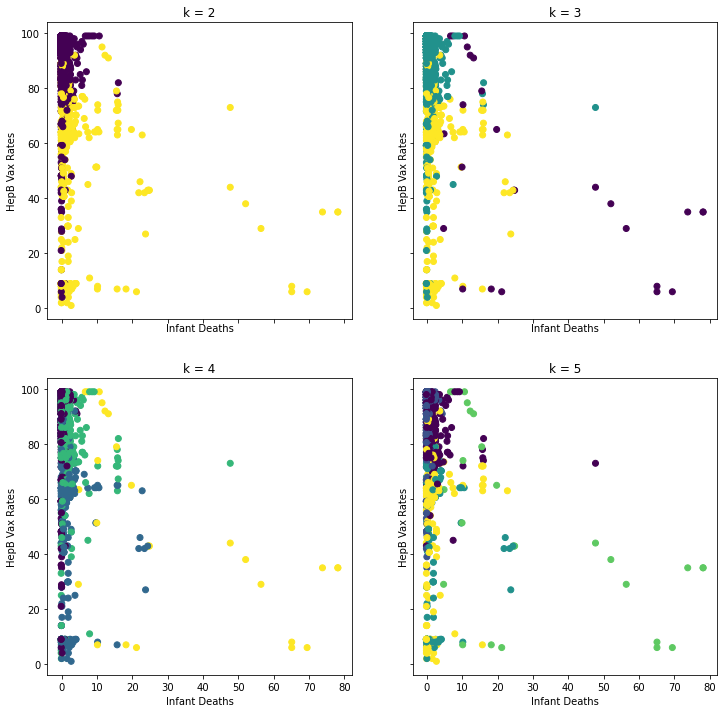

In [22]:
# let's create some clusters

# visualize k for infant deaths and hep b
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

# drop object column
X = train_scaled.drop(columns='country')

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.infant_deaths, X.hep_b, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='Infant Deaths', ylabel='HepB Vax Rates')

These clusters are a hot mess and there is no visible clear cluster at this point.

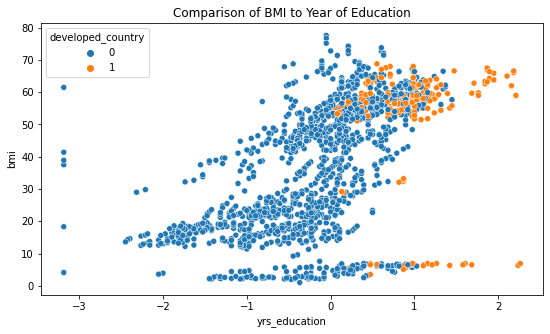

In [23]:
# anymore clustering possibilities?
plt.figure(figsize=(9,5))
sns.scatterplot(data=train_scaled, x='yrs_education', y='bmi', hue='developed_country')
plt.title('Comparison of BMI to Year of Education');

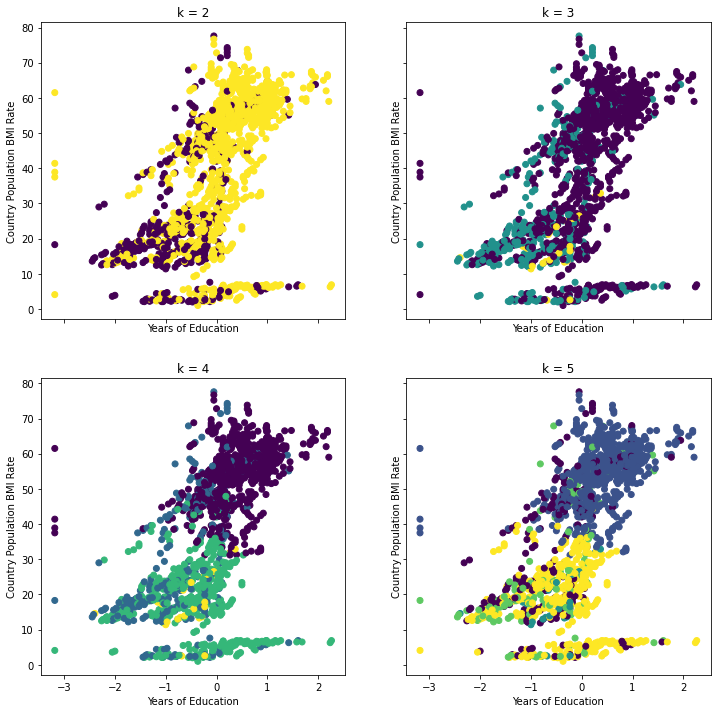

In [24]:
# visualize k for infant deaths and hep b
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

# drop object column
X = train_scaled.drop(columns='country')

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.yrs_education, X.bmi, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='Years of Education', ylabel='Country Population BMI Rate')

As it turns out, there are no prominent clusters here either, which surprises me.

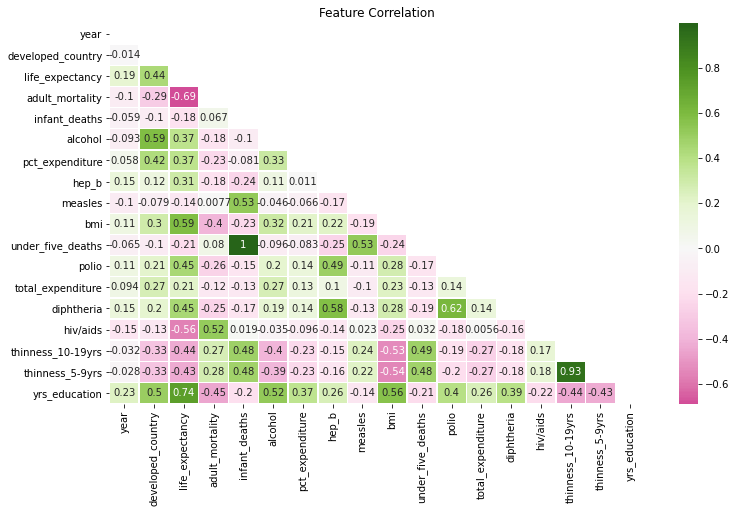

In [26]:
# take a look at a corner heatmap to assess correlation of independent and dependent variables
numerical = train_scaled
corr = numerical.corr()


plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap="PiYG", mask=mask)
plt.title('Feature Correlation')
plt.show()

**Takeaway**
\
I see a signification correlation of infant deaths and deaths under 5 years as well as thinness of variable ages to each other. These are repetitive features so it may be pointless to include both in the final model.

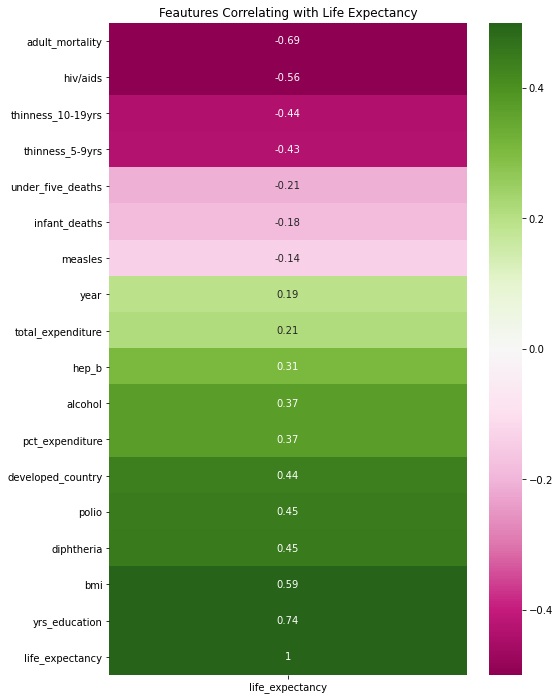

In [27]:
# Take a look at a heatmap of correlation to y target
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['life_expectancy']].sort_values(by='life_expectancy', ascending=True), cmap="PiYG", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Life Expectancy')
plt.show()

**Takeaway**
\
It's no surprise the year doesn't appear to have much correlation to life expectancy since the range is from 2000 to 2015.
\
----
**Statistics Test: Comparing means of two independent samples**
\
I will confirm using a two sample two tailed ttest. My assumption is that I can accept the null hypothesis and confirm no correlation.

${H_0}$ = The mean average of the first half of years == The mean average of the second half of years
\
${H_a}$ = The mean average of the first half of years != The mean average of the second half of years

In [28]:
# take a look at range for year
train_scaled.groupby('year').year.max()

year
-0.875   -0.875
-0.750   -0.750
-0.625   -0.625
-0.500   -0.500
-0.375   -0.375
-0.250   -0.250
-0.125   -0.125
 0.000    0.000
 0.125    0.125
 0.250    0.250
 0.375    0.375
 0.500    0.500
 0.625    0.625
 0.750    0.750
 0.875    0.875
 1.000    1.000
Name: year, dtype: float64

In [29]:
# set up our confidence interval
conf_int = .95
alpha = 1 - conf_int

# assign my samples for a two sample two tailed ttest
sample1 = train_scaled[train_scaled.year<=0].year
sample2 = train_scaled[train_scaled.year>0].year

# assess the variance between the two samples
sample1.var(), sample2.var()

(0.07970672602277944, 0.08005417381890872)

In [30]:
# utitilize our ttest, set variance to true
t, p = stats.ttest_ind(sample1, sample2, equal_var=True)


if (p < alpha) & (t > 0):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


Just as I suspected, year does not appear to have an association to life expectancy

-----
**Statistics Test: Confirming two variables are have no linear correlation**
\
I suspect the vaccination rate columns are going to be repetitive since most people would vaccinate altogether across the board. I use a pearson r test to confirm my suspicion by comparing HepB and Polio vaccination rates [amongst 1 year olds].
\
${H_0}$ = HepB vaccination rates have no correlation to Polio vaccination rates
\
${H_0}$ = HepB vaccination rates has a strong correlation to Polio vaccination rates

In [31]:
# set up our confidence interval
conf_int = 0.95
alpha = 1 - conf_int

corr, p = stats.pearsonr(train_scaled.hep_b, train_scaled.polio)

if p < alpha:
    print('We reject the null hypothesis, there is a correlation.')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis, there is a correlation.


Just as I suspected, there is a correlation of vaccination rates amongst the different columns! No need to have both in the final model.

In [32]:
# assess top features using recursive feature elimination applied with a linear regression algorithm, 
# compare to my suspected top features
top_features = explore.rfe(train_scaled.drop(columns=['country', 'life_expectancy']), train_scaled.life_expectancy, 9).to_list()
top_features

['developed_country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'pct_expenditure',
 'bmi',
 'under_five_deaths',
 'hiv/aids',
 'yrs_education']

### Explore Takeaways:
- We were able to get some good visuals using scatterplots.
- Clustering is a great possibility that could help us a lot in creating features
- The corner heatmap helped us see associations of independent variables and how some can be repetitive/duplicates
- Statistics supported my thought that year had no association to our target variable
- Using recursive feature elimination supported my suspisions of which features best predict y target.

## Modeling

In [33]:
# split X and y dataframes using my split_ytarget function
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_ytarget(train, validate, test, 'life_expectancy')

In [34]:
# assign my top features from exploration
X_train = train[top_features]
X_validate = validate[top_features]
X_test = test[top_features]

# since both infant_deaths and under_five_deaths made it into top features and they are similar,
# we will drop one
X_train.drop(columns='infant_deaths', inplace=True)
X_validate.drop(columns='infant_deaths', inplace=True)
X_test.drop(columns='infant_deaths', inplace=True)

<Figure size 864x504 with 0 Axes>

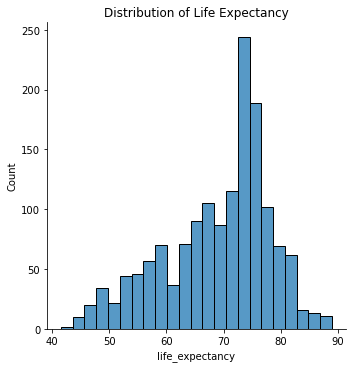

In [35]:
# set up our baseline model

# first visualize distribution of y target
plt.figure(figsize=(12,7))
sns.displot(y_train)
plt.title('Distribution of Life Expectancy');

### Baseline Model (Mean Average)

In [36]:
# utilize mean to create baseline model

# change y dataframes from arrays to dfs
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. Predict log error_baseline mean
baseline_mean = y_train['life_expectancy'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean


# 3. RMSE of log error mean
rmse_train = mean_squared_error(y_train.life_expectancy, y_train.baseline_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.life_expectancy, y_validate.baseline_mean)**(1/2)

print("RMSE using Mean Average\nTrain/In-Sample: ", round(rmse_train, 3), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 3))

RMSE using Mean Average
Train/In-Sample:  9.268 
Validate/Out-of-Sample:  9.34


### Model 1 (LinearRegression)

In [37]:
# create the model object
lm = LinearRegression(normalize=True)

# output result utilizing linear regression
rmse_train, rmse_validate = explore.rmse(lm, X_train, X_validate, y_train, y_validate, 'life_expectancy', 'model1')

RMSE for model1 using LinearRegression(normalize=True) 
Training/In-Sample:  4.243287769187369 
Validation/Out-of-Sample:  4.53623009201453



### Model 2 (TweedieRegressor)

In [38]:
# now let's try tweedie regressor
glm = TweedieRegressor(power=0, alpha=1.0)

# output result utilizing tweedie regressor
rmse_train, rmse_validate = explore.rmse(glm, X_train, X_validate, y_train, y_validate, 'life_expectancy', 'model2')

RMSE for model2 using TweedieRegressor(power=0) 
Training/In-Sample:  4.9758390215252915 
Validation/Out-of-Sample:  5.291497577288724



### Model 3 (LassoLars)

In [39]:
# let's see what the output is for lassolars, despite recursive features not being the best for this
# model, let's see what kind of rmse we can get for it
lars = LassoLars(alpha=1.0)

# output rmse results
rmse_train, rmse_validate = explore.rmse(lars, X_train, X_validate, y_train, y_validate, 'life_expectancy', 'model3')

RMSE for model3 using LassoLars() 
Training/In-Sample:  9.267766349581116 
Validation/Out-of-Sample:  9.340476678053715



### Model 4 (PolynomialRegression: degree=2)

In [40]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# bring in linear regression
lm2 = LinearRegression(normalize=True)


# fit and transform to train data via polynomialfeatures
X_train2 = pf.fit_transform(X_train)

# transform transform
X_validate2 = pf.transform(X_validate)

# output rmse test result
rmse_train, rmse_validate = explore.rmse(lm2, X_train2, X_validate2, y_train, y_validate, 'life_expectancy', 'model4')

RMSE for model4 using LinearRegression(normalize=True) 
Training/In-Sample:  3.2171175547913196 
Validation/Out-of-Sample:  3.508582492630084



### Model 5 (PolynomialRegression: degree=3)

In [41]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# assign new variable for linear regression
lm3 = LinearRegression(normalize=True)

# fit and transform to train data
X_train2 = pf.fit_transform(X_train)

# transform x_validate
X_validate2 = pf.transform(X_validate)

# output rmse result
rmse_train, rmse_validate = explore.rmse(lm2, X_train2, X_validate2, y_train, y_validate, 'life_expectancy', 'model5')

RMSE for model5 using LinearRegression(normalize=True) 
Training/In-Sample:  2.719458416136755 
Validation/Out-of-Sample:  3.273585295640589



Model 5 did very well despite the slight possibility of it being overfit. 

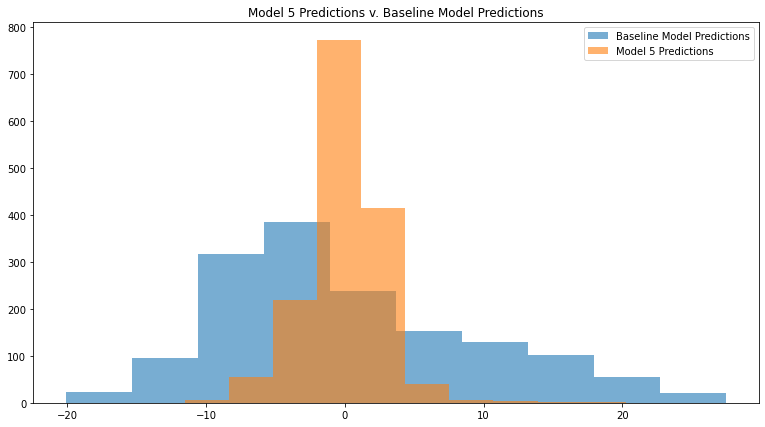

In [42]:
# compare residuals of Model 5 to the baseline model

# create a residual column
X_train['residual'] = (y_train.model5 - y_train.life_expectancy)

# create a residual baseline column
X_train['residual_mean_baseline'] = (y_train.life_expectancy.mean() - y_train.life_expectancy)
    
fig, ax = plt.subplots(figsize=(13,7))

ax.hist(X_train.residual_mean_baseline, label='Baseline Model Predictions', alpha=.6)
ax.hist(X_train.residual, label='Model 5 Predictions', alpha=.6)
ax.legend()

plt.title('Model 5 Predictions v. Baseline Model Predictions')
plt.show()

As we can see here, Model 5 is a lot more normally distributed and closer to 0 than the baseline model, which is what we aim for.

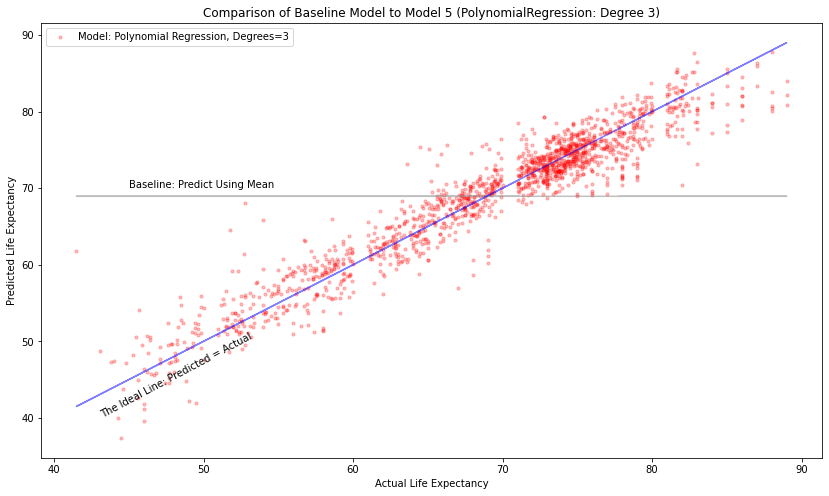

In [43]:
# another look at plotting residual

plt.figure(figsize=(14,8))
plt.plot(y_train.life_expectancy, y_train.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (45, 70))

plt.plot(y_train.life_expectancy, y_train.life_expectancy, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (43, 40), rotation=28)

plt.scatter(y_train.life_expectancy, y_train.model5,
            alpha=.25, color="red", s=10, label="Model: Polynomial Regression, Degrees=3")



plt.legend()
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Comparison of Baseline Model to Model 5 (PolynomialRegression: Degree 3)")

plt.show()

Here we can clearly see that Model 5 follows the regression line a lot more accurately than our baseline model.

### Modeling Takeaways:
- Model 1 and Model 5 perfromed the best out of all the models
- Moving forward which do we choose? There is a possibility Model 5 is overfit.
- I don't think there is a major disparity in RMSE train versus validate on Model 5
- I choose Model 5 to move forward with and test on unseen data.

**Test Model 5**

In [44]:
# drop the residual columns I created
cols = ['residual', 'residual_mean_baseline']
X_train.drop(columns=cols, inplace=True)
X_train.shape, X_validate.shape, X_test.shape

((1516, 8), (651, 8), (542, 8))

In [45]:
# test my model
X_test2 = pf.transform(X_test)
y_test['model5'] = lm2.predict(X_test2)

# evaluate RMSE for test
rmse_test = mean_squared_error(y_test['life_expectancy'], y_test['model5'])**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  2.719458416136755 
Validation/Out-of-Sample:  3.273585295640589 
Test/Out-of-Sample:  3.430535627597693


Nicely done Model 5.

## Conclusion:
- We acquired and prepared our data by imputing and dropping nulls, dropping unnecessary columns and renaming features.
- Through exploratory scatterplots and heatmaps, as well as using recursive feature method, we were able to hone in on top drivers of life expectancy
- I created a baseline model using mean average of life expectancy and an additional five other models using different algorithms.
- In the end, the PolynomialRegression using 3 degrees performed the best on the unseen validate dataframe.
- We moved forward with using Model 5 on the unseen test data set and achieved an RMSE of 3.43. This means our model's prediction of life expectancy is only off by an average of 3.43 years.

\
**With more time:**
- I would continue to impute the remainder of my nulls as opposed to just dropping the rest of them.
- I would also address the outliers/skewed data that was entered incorrectly (such as population).
- I would create bins amongst the different vaccination rates to see if I can create one column for vaccination rates.
- I would continue to utilize clustering to create new features and see how I can create more correlated features.
- I would assess the outliers and/or utilize different scaling methods to see if that has an impact on model performance.